## GeoCroissant to OGC-TDML (pytdml) Converter
<img src="../../asset/GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 20px;"/>

This notebook demonstrates how to convert a dataset from the [GeoCroissant](https://github.com/mlcommons/croissant) JSON-LD format to the [OGC-TDML](https://github.com/openrsgis/pytdml) using both `mlcroissant` and `pytdml` for validation and schema compliance.

### **How it works:**
- **Validates** the GeoCroissant JSON using `mlcroissant` for standard metadata fields.
- **Directly extracts** the `variableMeasured` and `distribution` arrays from the JSON to ensure all classes, bands, and data entries are captured.
- **Builds a TDML object** using the `pytdml` object model, ensuring strict schema compliance.
- **Writes the TDML file** using `pytdml.io.write_to_json`.

In [1]:
!pip install s3fs pystac https://github.com/openrsgis/pytdml/releases/download/v1.2.0/pytdml-1.2.0-py3-none-any.whl -q

### Run the GeoCroissant to TDML Converter

The following command runs the converter script to transform your GeoCroissant JSON file into a TDML-compliant JSON file.

- **Input:** `hls_burn_scars_croissant.json` (GeoCroissant format)
- **Output:** `hls_burn_scars_geocroissant_to_ogctdml.json` (TDML format)

In [13]:
!python geocr-to-ogc_tdml.py hls_burn_scars_croissant.json hls_burn_scars_tdml_output.json

Note: GeoCroissant uses FileSet structure. Enumerating files from filesystem...
Found 804 image files and 804 mask files
TDML file written to hls_burn_scars_tdml_output.json


### Load and Inspect the OGC-TDML Dataset

This code loads the generated TDML file using `pytdml` and prints key dataset information:

- **Purpose:**  
  - Verifies that the TDML file is valid and can be loaded.
  - Displays the dataset name, number of training samples, and number of classes.
- **Expected Output:**  
  - The correct dataset name.
  - The total number of image/mask pairs.
  - The number of semantic classes in the dataset.

In [14]:
import pytdml.io
    
training_dataset = pytdml.io.read_from_json("hls_burn_scars_tdml_output.json")  # read from TDML json file
print("Load training dataset: " + training_dataset.name)
print("Number of training samples: " + str(training_dataset.amount_of_training_data))
print("Number of classes: " + str(training_dataset.number_of_classes))

Load training dataset: hls_burn_scars
Number of training samples: 804
Number of classes: 2


## Loading and Visualizing a TDML Segmentation Dataset with Rasterio and PyTorch

This example demonstrates how to load a segmentation dataset described by a TDML (Training Data Markup Language) JSON file, download the image and mask pairs, and visualize them using PyTorch, Rasterio, and Matplotlib.

Total samples in dataset: 804
Image shape: torch.Size([6, 512, 512])
Mask shape: torch.Size([512, 512])
Unique mask values: tensor([-1,  0,  1])


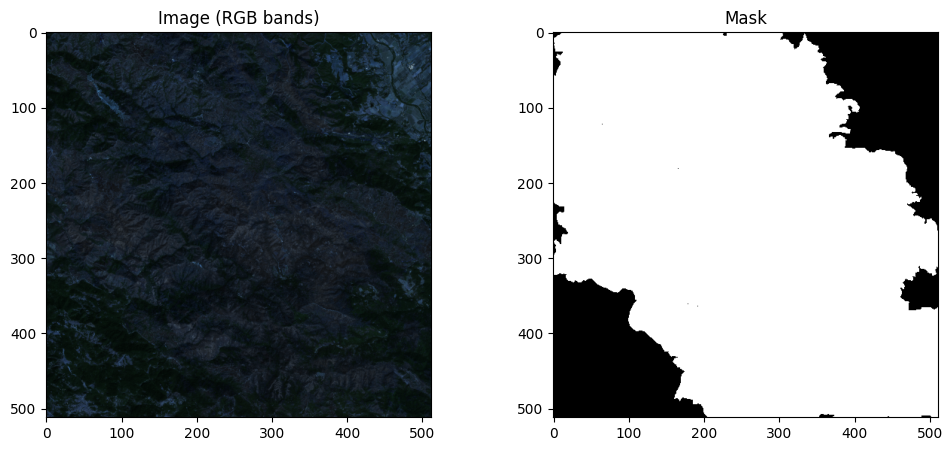

In [16]:
import os
import requests
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import rasterio
import json
import matplotlib.pyplot as plt

class TDMLSegmentationDatasetRasterio(Dataset):
    def __init__(self, tdml_path, transform=None, cache_dir="./cache"):
        with open(tdml_path) as f:
            tdml = json.load(f)
        self.data = tdml["data"]
        self.transform = transform
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

        # Pair image and mask URLs
        self.pairs = []
        for entry in self.data:
            img_url = entry.get("dataURL", [None])[0]
            mask_url = None
            if entry.get("labels") and entry["labels"][0].get("imageURL"):
                mask_url = entry["labels"][0]["imageURL"][0]
            if img_url and mask_url:
                self.pairs.append((img_url, mask_url))

    def _get_file_path(self, url_or_path):
        """Handle both local file paths and remote URLs"""
        # Check if it's a local file path
        if os.path.isabs(url_or_path) or os.path.exists(url_or_path):
            return url_or_path
        
        # Check if it's a URL that needs to be downloaded
        if url_or_path.startswith(('http://', 'https://')):
            filename = os.path.join(self.cache_dir, os.path.basename(url_or_path))
            if not os.path.exists(filename):
                r = requests.get(url_or_path)
                r.raise_for_status()
                with open(filename, "wb") as f:
                    f.write(r.content)
            return filename
        
        # Otherwise, treat as relative path
        return url_or_path

    def _load_image(self, path):
        with rasterio.open(path) as src:
            # Read all bands
            img = src.read()  # Shape: (bands, height, width)
            # Transpose to (height, width, bands)
            img = np.transpose(img, (1, 2, 0))
        return img

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_url, mask_url = self.pairs[idx]
        img_path = self._get_file_path(img_url)
        mask_path = self._get_file_path(mask_url)
        img = self._load_image(img_path)
        mask = self._load_image(mask_path)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float()  # (C, H, W)
        mask = torch.from_numpy(mask).long()
        if mask.ndim == 3:
            mask = mask.squeeze()
        return img, mask

# Usage example:
dataset = TDMLSegmentationDatasetRasterio("hls_burn_scars_tdml_output.json", transform=None)
print(f"Total samples in dataset: {len(dataset)}")
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)
print("Unique mask values:", torch.unique(mask))

# Plotting
img_np = img.permute(1, 2, 0).numpy()
mask_np = mask.numpy()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
if img_np.shape[2] >= 3:
    plt.imshow(img_np[:, :, :3] / np.max(img_np[:, :, :3]))
    plt.title("Image (RGB bands)")
else:
    plt.imshow(img_np[:, :, 0], cmap='grey')
    plt.title("Image (Band 1)")
plt.axis('on')
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='grey', vmin=0, vmax=1)
plt.title("Mask")
plt.axis('on')
plt.show()